# 0. Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from src.dataset import FormatDataset
from src.model import UNet
from src.plot import (
    plot_train_and_validation_error,
    plot_dice_and_iou,
    plot_all_roc_curves,
    plot_confusion_matrices2,
    show_predicted_images
)
from src.save_data import (
    load_checkpoint,
    save_checkpoint, save_metrics_summary, load_metrics_summary, save_confusion_matrix, load_confusion_matrices,
    save_roc_auc_summary, load_roc_auc_summary
)
from src.train_test_validate import (
    train,
    validate,
    test,
)

# 1. Hyperparameters and Directories

In [2]:
# Hyperparameters
DEVICE = "mps" if torch.mps.is_available() else "cpu"
BATCH_SIZE = 4
START_EPOCH = 5
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_WORKERS = 1
PIN_MEMORY = False  # For GPU tasks, not for MAC

## For model
LOAD_MODEL = True
TRAIN_MODEL = False
VALIDATE_MODEL = False  # If TRAIN_MODEL = True then make it false; already done inside train loop
TEST_MODEL = True

IMAGE_HEIGHT = 572
IMAGE_WIDTH = 572
MODEL_CHECKPOINT_PATH = "model_checkpoint.pth.tar"
SAVE_PREDICTIONS_DIR = "predictions_images/"

## For Directories
TRAIN_IMG_DIR = "data/segmentation_task/train/images/"
TRAIN_MASK_DIR = "data/segmentation_task/train/masks/"
VAL_IMG_DIR = "data/segmentation_task/val/images/"
VAL_MASK_DIR = "data/segmentation_task/val/masks/"
TEST_IMG_DIR = "data/segmentation_task/test/images/"
TEST_MASK_DIR = "data/segmentation_task/test/masks/"

# 2. Dataset and DataLoader

In [3]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

validate_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT, IMAGE_WIDTH),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

train_dataset = FormatDataset(
    image_dir=TRAIN_IMG_DIR,
    mask_dir=TRAIN_MASK_DIR,
    transform=train_transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
)

test_dataset = FormatDataset(
    image_dir=VAL_IMG_DIR,
    mask_dir=VAL_MASK_DIR,
    transform=validate_transform,
)

val_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

test_loader = DataLoader(
    FormatDataset(
        image_dir=TEST_IMG_DIR,
        mask_dir=TEST_MASK_DIR,
        transform=validate_transform,
    ),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
)

# 3. Initializations

In [4]:
model = UNet(in_ch=3, out_ch=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [5]:
load_checkpoint(model, optimizer, filename=MODEL_CHECKPOINT_PATH)

Loading checkpoint ./checkpoints/model_checkpoint.pth.tar


# 4. Train and Validate Model

In [ ]:
for epoch in range(START_EPOCH, NUM_EPOCHS):
    print(f"-----------| EPOCH {epoch} |------------")
    print(f"-----------| TRAINING: calculate loss |------------")
    training_loss = train(train_loader, model, optimizer, loss_fn, device=DEVICE, clip_grad=0.1)

    print(f"-----------| VALIDATION: check accuracy |------------")
    validation_loss, dice, iou, confusion, fpr, tpr, roc_auc = validate(val_loader, model, loss_fn,device=DEVICE)

    save_metrics_summary(epoch, training_loss, validation_loss, dice, iou)
    save_confusion_matrix(epoch, confusion)
    save_roc_auc_summary(epoch, fpr, tpr, roc_auc)

    # save model
    save_checkpoint(epoch, model, optimizer, filename=MODEL_CHECKPOINT_PATH)

# 5. Plot Metrices and Graph

In [6]:
# Load all saved metrics and Load ROC and AUC summary
epochs, training_loss, validation_loss, dice, iou = load_metrics_summary()
cms = load_confusion_matrices()
fprs, tprs, aucs = load_roc_auc_summary(num_epochs=len(epochs))

### a. Training and Validation Loss Graph

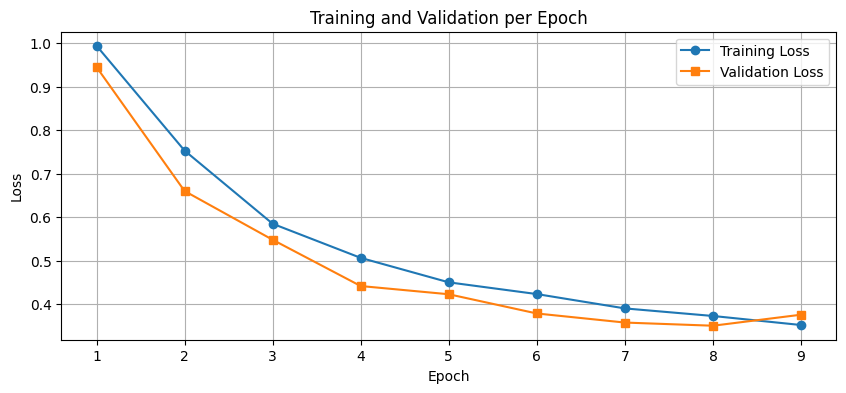

In [7]:
plot_train_and_validation_error(epochs, training_loss, validation_loss)

### b. DICE and IoU Graph

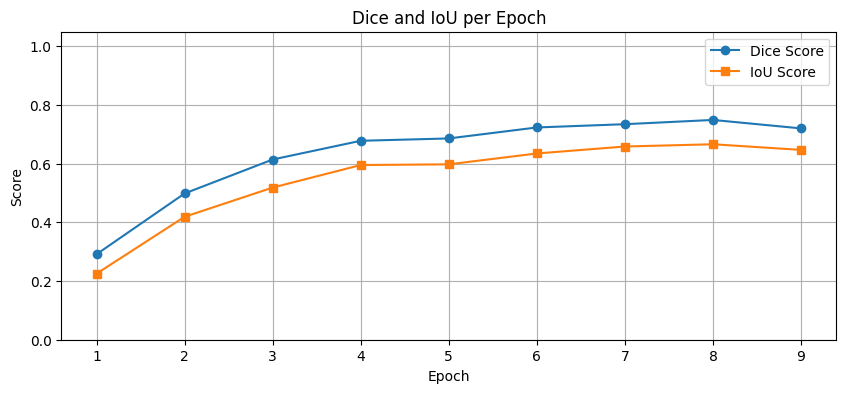

In [8]:
plot_dice_and_iou(epochs, dice, iou)

### c. Confusion Matrices -> per-pixel confusion matrix for binary segmentation.

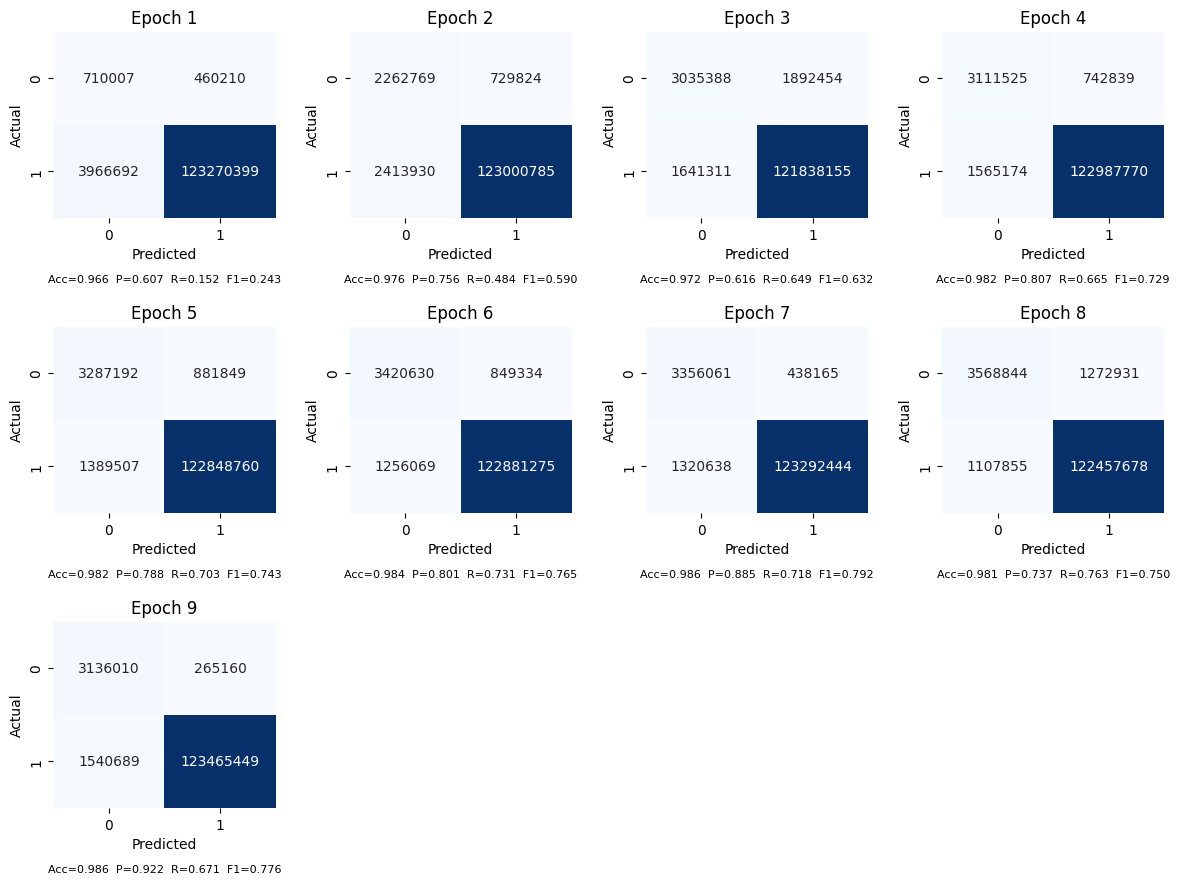

In [9]:
plot_confusion_matrices2(epochs, cms)

### d. ROC curve metrics and AUC for binary segmentation

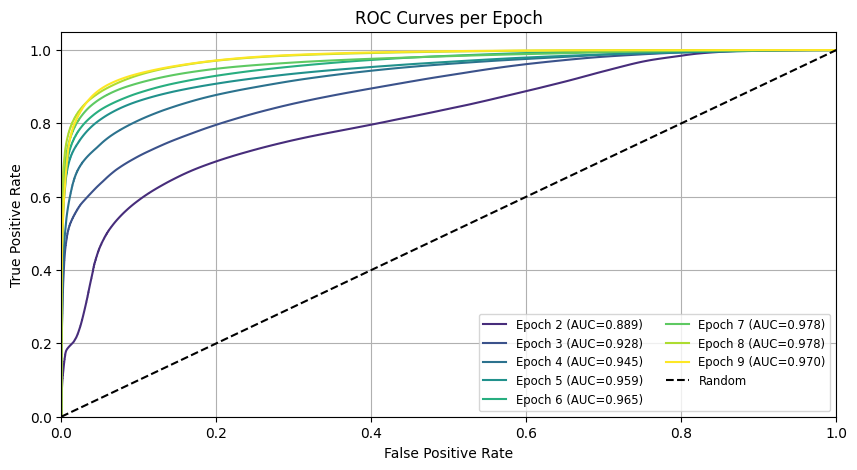

In [10]:
plot_all_roc_curves(epochs, fprs, tprs, aucs)

# 5. Test Model

In [11]:
test_model = UNet(in_ch=3, out_ch=1).to(DEVICE)
load_checkpoint(test_model, optimizer, filename=MODEL_CHECKPOINT_PATH)

Loading checkpoint ./checkpoints/model_checkpoint.pth.tar


In [12]:
print(f"-----------| TESTING: print sample images to a folder |------------")
test(test_loader, test_model, folder=SAVE_PREDICTIONS_DIR, device=DEVICE)

-----------| TESTING: print sample images to a folder |------------


1it [00:02,  2.86s/it]

Saved batch 0 paper-style visualizations


1it [00:07,  7.86s/it]


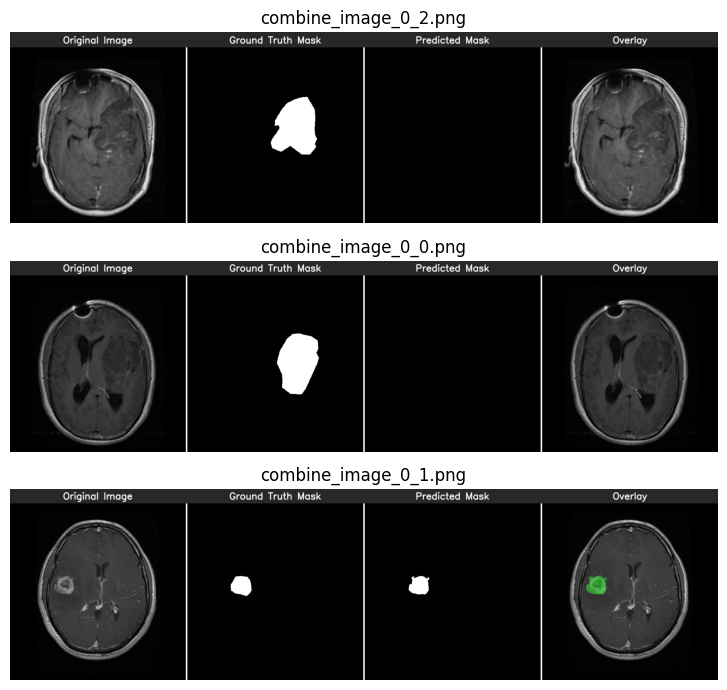

In [13]:
show_predicted_images(SAVE_PREDICTIONS_DIR)